# JAX implementation

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])
from phd.plot import book_config, get_current_config as plt_cfg
book_config.set_as_current()

results_folder = '../results/II_PINNs'  
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# --- Figure settings ---
save_fig = True
if save_fig:
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'

## Primitive operations

In [2]:
import importlib
# from jax import core
from jax._src import core

# List of key internal modules where primitives are defined
modules = [
    "jax._src.lax.lax",
    "jax._src.lax.linalg",
    "jax._src.lax.slicing",
    "jax._src.lax.reduction",
    "jax._src.lax.control_flow",
    "jax._src.lax.fft",
    "jax._src.lax.operators",
]

all_primitives = {}

for modname in modules:
    try:
        mod = importlib.import_module(modname)
        primitives = {
            name: obj
            for name, obj in vars(mod).items()
            if isinstance(obj, core.Primitive)
        }
        all_primitives[modname.split(".")[-1]] = sorted(p.name for p in primitives.values())
    except ModuleNotFoundError:
        pass

# Print nicely grouped
print("-------------------------")
print("JAX Primitive Operations:")
print("-------------------------")
for group, prims in all_primitives.items():
    print(f"\n🔹 {group.upper()} ({len(prims)} primitives)")
    print(", ".join(prims))

-------------------------
JAX Primitive Operations:
-------------------------

🔹 LAX (103 primitives)
abs, acos, acosh, add, after_all, and, argmax, argmin, asin, asinh, atan, atan2, atanh, bitcast_convert_type, broadcast_in_dim, cbrt, ceil, clamp, clz, complex, composite, concatenate, conj, convert_element_type, copy, cos, cosh, create_token, dce_sink, div, dot_general, empty, empty2, eq, eq_to, exp, exp2, expm1, floor, from_edtype, ge, gt, imag, integer_pow, iota, is_finite, le, le_to, log, log1p, logistic, lt, lt_to, max, min, mul, ne, neg, nextafter, not, optimization_barrier, or, pad, population_count, pow, ragged_dot_general, real, reduce, reduce_and, reduce_max, reduce_min, reduce_or, reduce_precision, reduce_prod, reduce_sum, reduce_xor, rem, reshape, rev, rng_bit_generator, rng_uniform, round, rsqrt, select_n, shift_left, shift_right_arithmetic, shift_right_logical, sign, sin, sinh, sort, split, sqrt, square, squeeze, sub, tan, tanh, tie, to_edtype, top_k, transpose, xor

🔹 LI

## Computationnal graph

{ lambda ; a:f32[]. let
    b:f32[] = sin a
    c:f32[] = integer_pow[y=2] a
    d:f32[] = exp c
    e:f32[] = mul b d
  in (e,) }


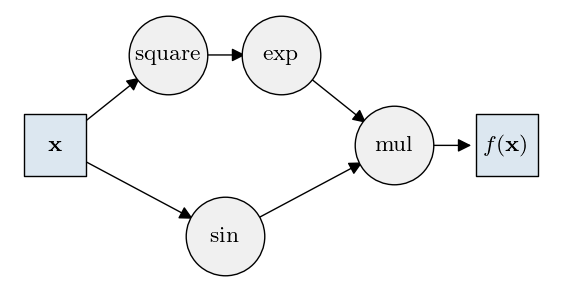

Figure of width 0.74 x page width saved at ./images/jaxpr_computation_graph.png + .pgf


In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import jax
import jax.numpy as jnp

# Define our function
def f(x):
    return jnp.sin(x) * jnp.exp(x**2)

# 1️⃣  Trace the function with JAX
x0 = 1.0
jaxpr = jax.make_jaxpr(f)(x0)
print(jaxpr)

# Node layout and types
pos = {r"$\mathbf{x}$": (0, 0), 
       "square": (0.5, 0.4), 
       "exp": (1.0, 0.4),
       "sin": (0.75, -0.4), 
       "mul": (1.5, 0), 
       r"$f(\mathbf{x})$": (2.0, 0)}

types = {r"$\mathbf{x}$": "io", "square": "op", "exp": "op",
         "sin": "op", "mul": "op", r"$f(\mathbf{x})$": "io"}

edges = [(r"$\mathbf{x}$","square"),("square","exp"),
         (r"$\mathbf{x}$","sin"),("sin","mul"),("exp","mul"),("mul",r"$f(\mathbf{x})$")]

# Style dictionaries
colors = {"io": "#DCE7F0", "op": "#F0F0F0"}
shapes = {"io": "s", "op": "o"}
sizes  = {"io": 500, "op": 800}

# Plot
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=200)
for n,(x,y) in pos.items():
    t = types[n]
    ax.scatter(x,y,s=sizes[t],c=colors[t],edgecolors="black",
               marker=shapes[t],zorder=2,linewidths=0.5)
    ax.text(x,y,n,ha="center",va="center",fontsize=8)
for s,e in edges:
    ax.add_patch(FancyArrowPatch(pos[s],pos[e],arrowstyle='-|>',color='black',
                                 linewidth=0.5,shrinkA=10,shrinkB=13,mutation_scale=10))
ax.set(xlim=(-0.2,2.2),ylim=(-0.6,0.6),aspect="equal"); ax.axis("off")
plt.show()

# Save the figure
if save_fig:
    images_folder = './images'
    fig.savefig(os.path.join(images_folder, 'jaxpr_computation_graph.png'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(images_folder, 'pgf', 'jaxpr_computation_graph.pgf'), bbox_inches='tight')
    print(f"Figure of width {fig.get_size_inches()[0]/plt_cfg().page_width:.2f} x page width saved at {os.path.join(images_folder, 'jaxpr_computation_graph.png')} + .pgf")

## JIT compilation to optimize performance

Non-jitted: 0.063s
First jit (compile): 0.329s
Subsequent jit: 0.006s
Speed-up: 10.0×
GPU jit: 0.001s
Speed-up GPU: 42.6×


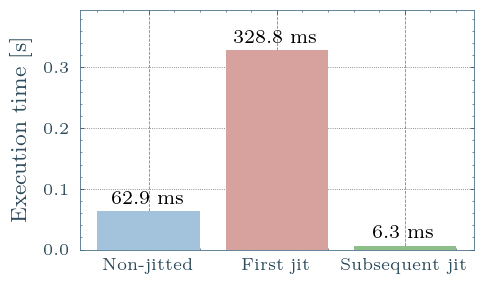

Figure of width 0.53 x page width saved at ./images/jax_jit_performance.png + .pgf


In [6]:
import jax, jax.numpy as jnp
import numpy as np, timeit, matplotlib.pyplot as plt

# --- Function ---
def f(x):
    for _ in range(100):
        x = jnp.sin(x) * jnp.exp(-x**2)
    return x

x = jnp.linspace(-5, 5, 100_000)

def time_run(fn, n=3):
    t = []
    for _ in range(n):
        s = timeit.default_timer()
        fn(x).block_until_ready()
        t.append(timeit.default_timer() - s)
    return np.median(t)

# --- Warm-up ---
with jax.default_device(jax.devices("cpu")[0]):
    f(x).block_until_ready()

# --- CPU timings ---
with jax.default_device(jax.devices("cpu")[0]):
    f_jit = jax.jit(f)
    t_nonjit = time_run(f)
    t_first = time_run(lambda x=x: jax.jit(f)(x), n=1)  # includes compile
    f_jit(x).block_until_ready()
    t_jitted = time_run(f_jit)

print(f"Non-jitted: {t_nonjit:.3f}s\n"
      f"First jit (compile): {t_first:.3f}s\n"
      f"Subsequent jit: {t_jitted:.3f}s\n"
      f"Speed-up: {t_nonjit/t_jitted:.1f}×")

labels = ["Non-jitted", "First jit", "Subsequent jit"]
times = [t_nonjit, t_first, t_jitted]
colors = ["#A2C3DB", "#D7A29E", "#8FBF88"]

# --- Optional GPU ---
gpu = next((d for d in jax.devices() if "nvidia" in d.device_kind.lower() or "gpu" in d.device_kind.lower()), None)
t_gpu = None
if gpu:
    with jax.default_device(gpu):
        f_jit_gpu = jax.jit(f)
        f_jit_gpu(x).block_until_ready()
        t_gpu = time_run(f_jit_gpu)
    print(f"GPU jit: {t_gpu:.3f}s")
    print(f"Speed-up GPU: {t_nonjit/t_gpu:.1f}×")


# --- Plot ---
fig, ax = plt.subplots(figsize=(2.5, 1.5), dpi=200)
bars = ax.bar(labels, times, color=colors)

# --- Labels ---
for lbl, val, bar in zip(labels, times, bars):
    x, y = bar.get_x() + bar.get_width()/2, bar.get_height()
    ax.text(x, y+0.02, f"{val*1000:.1f} ms", ha="center", va="center", fontsize=7)

ax.set_ylabel("Execution time [s]")
ax.set_ylim(0, max(times + ([t_gpu] if t_gpu else [])) * 1.2)
ax.grid(axis="y", linestyle=":", alpha=0.6)
fig.tight_layout()
plt.show()

if save_fig:
    images_folder = './images'
    fig.savefig(os.path.join(images_folder, 'jax_jit_performance.png'), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(images_folder, 'pgf', 'jax_jit_performance.pgf'), bbox_inches='tight')
    print(f"Figure of width {fig.get_size_inches()[0]/plt_cfg().page_width:.2f} x page width saved at {os.path.join(images_folder, 'jax_jit_performance.png')} + .pgf")
